In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report


In [112]:
# Importing the dataset
excel_path = 'S&P 500 Index Dataset.xlsx'
snp500 = pd.read_excel(excel_path, sheet_name=1, header=0, index_col=0, parse_dates=False)
snp500.shape

(9243, 134)

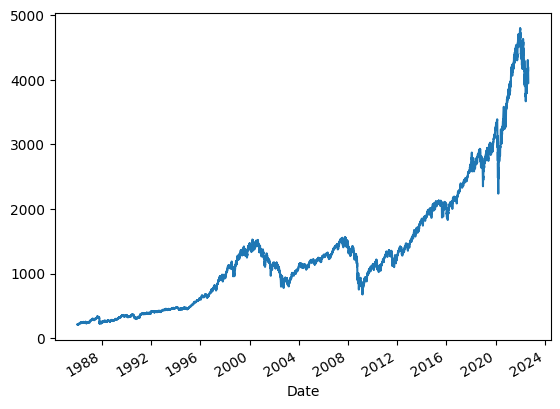

mean1=685.921435, mean2=2008.499989
variance1=151960.760681, variance2=943862.496826


In [113]:
# check for the seasonlity

snp500['Close'].plot()
plt.show()

X = snp500['Close'].values
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

# Although the data is non-stationsary, this doesn't necessarily impact the ability to predict directional changes for a binary indicator.

In [114]:
# the direction after t+5
snp500['Direction'] = (snp500['Close'].shift(-5)>snp500['Close']).astype(int)
snp500 = snp500.dropna()
snp500.tail(15)

,Open,High,Low,Close,Volume,p_sma_5,p_sma_10,p_sma_20,p_sma_50,p_sma_100,...,pvo_signal,pvo_hist,cmo,cmo_signal,dmi,ko,ko_signal,smi,smi_signal,Direction
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-11,4227.399902,4257.910156,4201.410156,4207.270020,3925060000,4165.046094,4147.245020,4050.378003,3949.092607,4109.603413,...,-1.168650,1.705267,50.464296,45.540754,67.332810,2.722568e+10,2.371316e+10,75.510990,79.217106,1
2022-08-12,4225.020020,4280.470215,4219.779785,4280.149902,3252290000,4192.038086,4162.231006,4071.227502,3952.671006,4107.793110,...,-1.011633,0.628069,56.510263,51.025509,79.951077,3.168775e+10,2.485238e+10,79.600369,79.408738,0
2022-08-15,4269.370117,4301.790039,4256.899902,4297.140137,3087740000,4223.454102,4180.082031,4094.542004,3955.077412,4105.648413,...,-1.105979,-0.377383,71.550330,61.287919,82.894963,3.532733e+10,2.634880e+10,86.119374,82.764056,0
2022-08-16,4290.459961,4325.279785,4277.770020,4305.200195,3792010000,4260.000098,4201.483057,4112.967517,3959.010615,4104.138013,...,-1.033963,0.288062,65.314407,63.301163,77.074705,4.007342e+10,2.830946e+10,89.356267,86.060161,0
2022-08-17,4280.399902,4302.180176,4253.080078,4274.040039,3293430000,4272.760059,4213.370068,4128.674524,3962.062812,4101.676812,...,-1.083743,-0.199119,48.760462,56.030813,69.168910,3.606480e+10,2.941737e+10,90.383509,88.221835,0
2022-08-18,4273.129883,4292.529785,4261.979980,4283.740234,2871990000,4288.054102,4226.550098,4142.914038,3964.524014,4099.083613,...,-1.400534,-1.267162,42.005411,49.018112,59.061556,3.389611e+10,3.005719e+10,85.235938,86.728886,0
2022-08-19,4266.310059,4266.310059,4218.700195,4228.479980,3210680000,4277.720117,4234.879102,4156.256543,3966.778213,4095.613213,...,-1.711756,-1.244889,26.864084,37.941098,60.699995,2.892017e+10,2.989476e+10,68.485605,77.607246,0
2022-08-22,4195.080078,4195.080078,4129.859863,4137.990234,3365220000,4245.890137,4234.672119,4164.814050,3969.181616,4090.677114,...,-1.927380,-0.862497,9.916147,23.928622,40.843250,1.862764e+10,2.828517e+10,33.546907,55.577076,0
2022-08-23,4133.089844,4159.770020,4124.029785,4128.729980,3117800000,4210.596094,4235.298096,4175.198047,3973.739014,4085.939912,...,-2.184587,-1.028828,-6.336855,8.795884,42.462281,9.762005e+09,2.563900e+10,-3.562859,26.007108,0


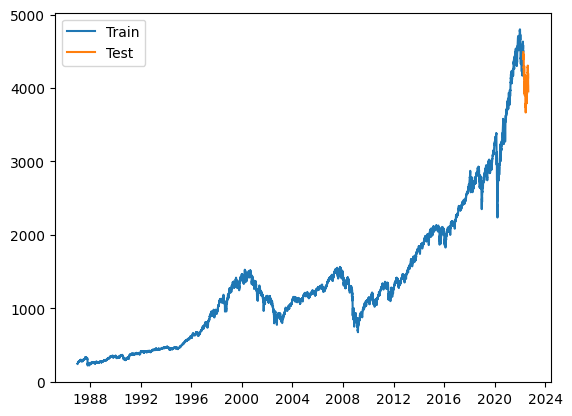

Direction
1    5145
0    3748
Name: count, dtype: int64

In [115]:
# keep the last 100 observations for testing
snp500_train = snp500.iloc[:-100]
snp500_test = snp500.iloc[-100:]


# Plotting the training data
plt.plot(snp500_train.index, snp500_train['Close'], label='Train')
# Plotting the test data
plt.plot(snp500_test.index, snp500_test['Close'], label='Test')
# Adding a legend to distinguish train and test data
plt.legend()
# Displaying the plot
plt.show()

# input
X = snp500_train.drop(columns=['Direction'])
# output
Y = snp500_train['Direction']

Y.value_counts()
# since the directions data are imblance, we need to do some resampling works

In [116]:
# resample
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
Y.value_counts()

Direction
1    5145
0    5145
Name: count, dtype: int64

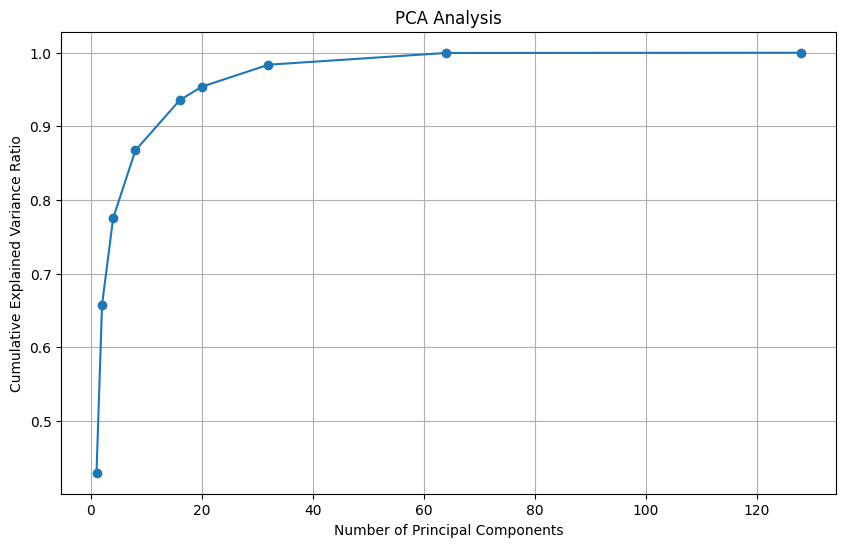


The explained variance:
{1: 0.42985288945593153, 2: 0.6580644039218548, 4: 0.775420753568405, 8: 0.8672694819730515, 16: 0.9355745117024764, 20: 0.953902627782781, 32: 0.9837249433764732, 64: 0.9996810949998949, 128: 1.0000000000000002}



In [117]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
df_scaled = scaler.fit_transform(X)

dimensions = [1, 2, 4, 8, 16, 20, 32, 64, 128]
explained_variance_ratio_cumulative = []
explained_variance_ratio_cumulative_dict = {}

for d in dimensions:
    #reduce the dimensionality
    pca = PCA(n_components=d, random_state=1)
    df_pca = pca.fit_transform(df_scaled)

    explained_variance_ratio_cumulative.append(pca.explained_variance_ratio_.sum())
    explained_variance_ratio_cumulative_dict[d] = pca.explained_variance_ratio_.sum()

# Plotting
plt.figure(figsize=(10,6))
plt.plot(dimensions, explained_variance_ratio_cumulative, marker='o')
plt.title('PCA Analysis')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.show()


# The figures
print(f'''
The explained variance:
{explained_variance_ratio_cumulative_dict}
''')

# Trying with using d = 20

In [118]:
d = 20
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
df_scaled = scaler.fit_transform(X)
pca = PCA(n_components=d, random_state=1)
df_pca = pca.fit_transform(df_scaled)
df_pca.shape

# splitting the train and test set
X_train, X_val, y_train, y_val = train_test_split(df_pca, Y, test_size=0.2, random_state=1)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_val.shape}')

X_train shape: (8232, 20)
X_test shape: (2058, 20)
y_train shape: (8232,)
y_test shape: (2058,)


In [119]:
# A simple NN model
MLP_model = Sequential()
kernel_regularizer = kernel_regularizer=regularizers.l2(0.001)
# first layer
MLP_model.add(Dense(units = 100, activation = 'relu', input_shape = (20,), kernel_regularizer=kernel_regularizer)) 
MLP_model.add(Dropout(0.2))
MLP_model.add(BatchNormalization())
# second layer
MLP_model.add(Dense(units = 100, activation = 'relu', kernel_regularizer=kernel_regularizer)) 
MLP_model.add(Dropout(0.2))
MLP_model.add(BatchNormalization())
# third layer
MLP_model.add(Dense(units = 100, activation = 'relu', kernel_regularizer=kernel_regularizer)) 
MLP_model.add(Dropout(0.2))
MLP_model.add(BatchNormalization())
# forth layer
MLP_model.add(Dense(units = 100, activation = 'relu', kernel_regularizer=kernel_regularizer)) 
MLP_model.add(Dropout(0.2))
MLP_model.add(BatchNormalization())
# fifth layer
MLP_model.add(Dense(units = 100, activation = 'relu', kernel_regularizer=kernel_regularizer)) 
MLP_model.add(Dropout(0.2))
MLP_model.add(BatchNormalization())
# Output layer
MLP_model.add(Dense(1, activation = 'sigmoid'))

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
MLP_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

Epoch 1/100
258/258 [==============================] - 6s 6ms/step - loss: 1.1946 - accuracy: 0.5100 - val_loss: 1.1073 - val_accuracy: 0.5194
Epoch 2/100
258/258 [==============================] - 1s 5ms/step - loss: 1.1251 - accuracy: 0.5050 - val_loss: 1.0724 - val_accuracy: 0.5131
Epoch 3/100
258/258 [==============================] - 1s 4ms/step - loss: 1.0684 - accuracy: 0.5118 - val_loss: 1.0306 - val_accuracy: 0.5272
Epoch 4/100
258/258 [==============================] - 1s 4ms/step - loss: 1.0201 - accuracy: 0.5217 - val_loss: 0.9934 - val_accuracy: 0.5437
Epoch 5/100
258/258 [==============================] - 1s 4ms/step - loss: 0.9766 - accuracy: 0.5234 - val_loss: 0.9587 - val_accuracy: 0.5471
Epoch 6/100
258/258 [==============================] - 1s 4ms/step - loss: 0.9368 - accuracy: 0.5368 - val_loss: 0.9170 - val_accuracy: 0.5457
Epoch 7/100
258/258 [==============================] - 1s 5ms/step - loss: 0.9020 - accuracy: 0.5333 - val_loss: 0.8781 - val_accuracy: 0.5549

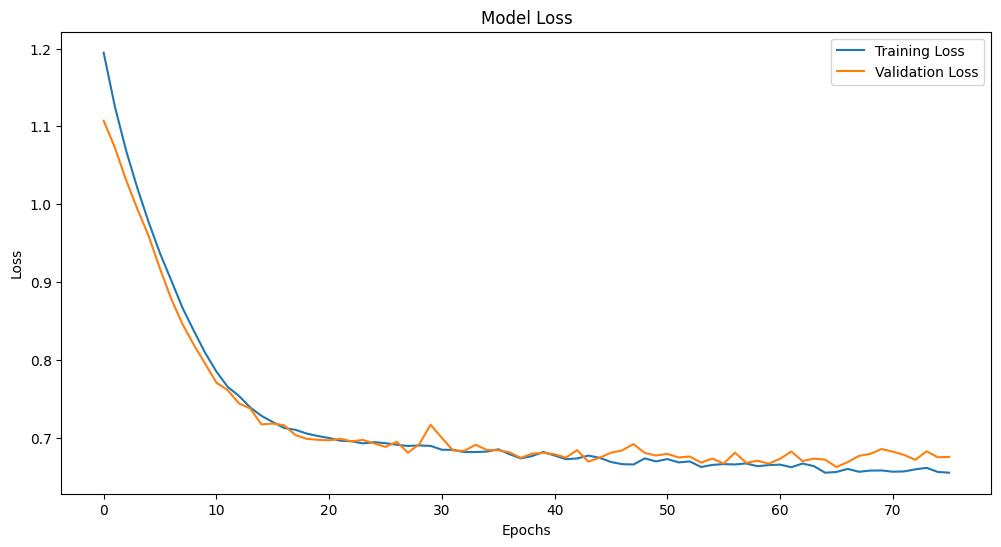

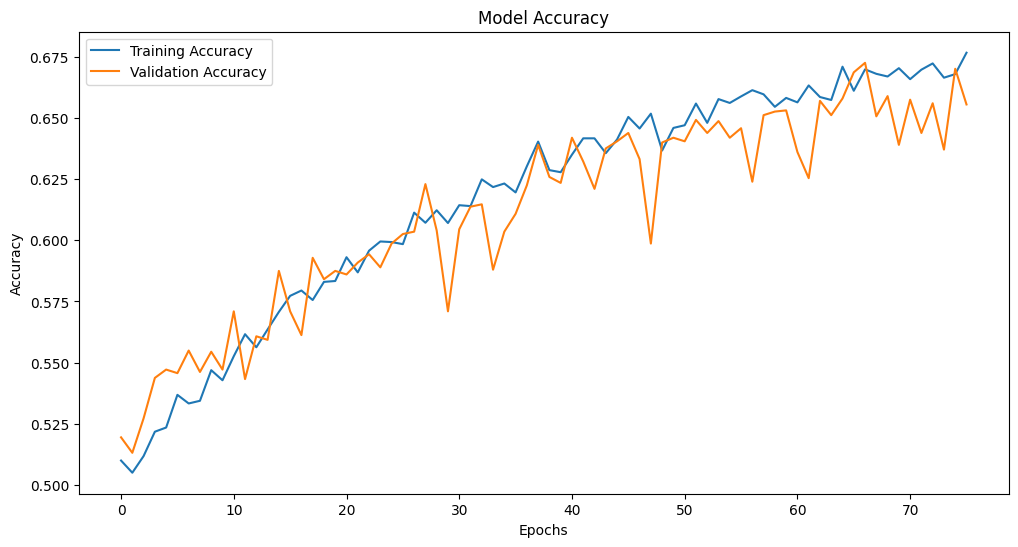

In [120]:
# training the model
start=time.time()
history = MLP_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])
end=time.time()
print("Running Time:", end - start)
# MLP_model.save('MLP_model.h5')

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

65/65 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      1025
           1       0.66      0.65      0.66      1033

    accuracy                           0.66      2058
   macro avg       0.66      0.66      0.66      2058
weighted avg       0.66      0.66      0.66      2058



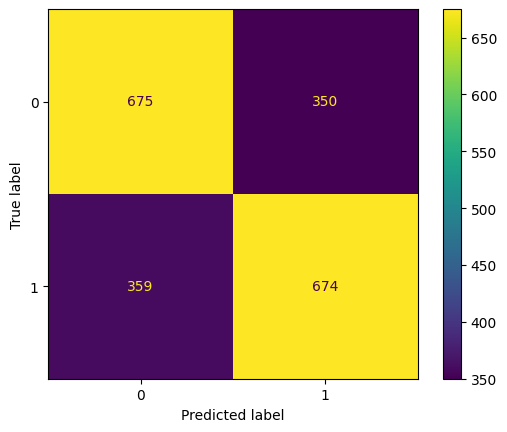

In [121]:
pred_val = (MLP_model.predict(X_val)> 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_val, pred_val)
print(classification_report(y_val, pred_val))

In [122]:
X_test = snp500_test.drop(columns=['Direction'])
Y_test = snp500_test['Direction']

X_test = scaler.transform(X_test)
X_test_pca = pca.transform(X_test)
Y_pred = MLP_model.predict(X_test_pca)
Y_pred_labels = (Y_pred > 0.5).astype(int)

loss, accuracy = MLP_model.evaluate(X_test_pca, Y_test, verbose=0)

cm = confusion_matrix(Y_test, Y_pred_labels)
print(cm)

print(classification_report(Y_test, Y_pred_labels))

4/4 [==============================] - 0s 2ms/step
[[28 24]
 [17 31]]
              precision    recall  f1-score   support

           0       0.62      0.54      0.58        52
           1       0.56      0.65      0.60        48

    accuracy                           0.59       100
   macro avg       0.59      0.59      0.59       100
weighted avg       0.59      0.59      0.59       100



In [123]:
X_test = snp500_test.drop(columns=['Direction'])
Y_test = snp500_test['Direction']

X_test = scaler.transform(X_test)
X_test_pca = pca.transform(X_test)
Y_pred = MLP_model.predict(X_test_pca)
Y_pred_labels = (Y_pred > 0.5).astype(int)

4/4 [==============================] - 0s 2ms/step


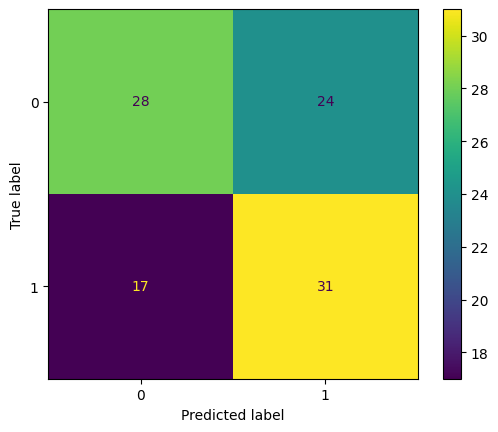

In [124]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_labels)
plt.show()

In [125]:
import json

list_to_save = Y_test.tolist()
with open('MLP_y_test_list.json', 'w') as f:
    json.dump(list_to_save, f)

list_to_save = Y_pred_labels.tolist()
with open('MLP_y_pred_list.json', 'w') as f:
    json.dump(list_to_save, f)

In [126]:
# for loading the model
# from keras.models import load_model

# # Returns a compiled model identical to the previous one
# model = load_model('MLP_model.h5')